# 1. Set Up

In [1]:
# !spack find -lvp tfel
# !echo "$(spack find -p tfel | awk '/\/mofem_install\// {print $NF "/lib"}')"
# %env LD_LIBRARY_PATH=/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib

In [2]:
import math
import os
import re
import sys
import time
import json
from pathlib import Path
import subprocess
import zipfile
import pydantic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import gmsh

sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import setup
import core
import custom_models as cm
import utils as ut
import plotting
import calculations as calc
import postprocess
    
import matplotlib
matplotlib.rc('figure', figsize=(7, 7))

# 2. Simulation Parameters

In [3]:
#in MPa
def initialize_parameters(custom_mesh_filepath: str = None, soil_model: cm.PropertyTypeEnum = cm.PropertyTypeEnum.le, **kwargs) -> cm.AttrDict:
    params = cm.AttrDict()
    setattr(params, "custom_mesh_filepath", custom_mesh_filepath)
    setattr(params, "soil_model", soil_model)
    for key,value in kwargs.items():
        setattr(params, key, value)
    params.interface = False
    params.pile_manager = cm.PileManager(x=0, y=0, z=0, dx=0, dy=0, R=1, r=0.975,
                                         stickup_height = 10,
                                         embedded_depth = -10.5,
                                preferred_model= cm.PropertyTypeEnum.le,
                                props = {
                                    cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=200000, poisson_ratio=0.49),
                                },
                                interface = params.interface,
                                )

    soil_layer_1 = cm.SoilLayer(
        depth = -2,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=96, poisson_ratio=0.49),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=96, poisson_ratio=0.49, HardeningSlope = 0.96, YieldStress = 0.3),
            cm.PropertyTypeEnum.vMDefault: cm.VonMisesProperties(youngs_modulus=96, poisson_ratio=0.49, HardeningSlope = 0.96, YieldStress = 0.3),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=96, poisson_ratio=0.49, phi=np.radians(5), c=0.25, v=np.radians(1)),
            cm.PropertyTypeEnum.dpHYPER: cm.DPHYPERProps(youngs_modulus=96, poisson_ratio=0.49, phi=np.radians(5), c=0.25, v=np.radians(1), proximity = 0.25),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
            }, 
            )
    soil_layer_2 = cm.SoilLayer(
        depth = -1.4,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=182.1, poisson_ratio=0.49),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=182.1, poisson_ratio=0.49, HardeningSlope = 1.821, YieldStress = 0.3),
            cm.PropertyTypeEnum.vMDefault: cm.VonMisesProperties(youngs_modulus=182.1, poisson_ratio=0.49, HardeningSlope = 1.821, YieldStress = 0.3),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=182.1, poisson_ratio=0.49, phi=np.radians(5), c=0.25, v=np.radians(1)),
            cm.PropertyTypeEnum.dpHYPER: cm.DPHYPERProps(youngs_modulus=182.1, poisson_ratio=0.49, phi=np.radians(5), c=0.25, v=np.radians(1), proximity = 0.25),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
            }, 
            )
    soil_layer_3 = cm.SoilLayer(
        depth = -7.1,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=351.3, poisson_ratio=0.49),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=351.3, poisson_ratio=0.49, HardeningSlope = 3.513, YieldStress = 0.3),
            cm.PropertyTypeEnum.vMDefault: cm.VonMisesProperties(youngs_modulus=182.1, poisson_ratio=0.49, HardeningSlope = 1.821, YieldStress = 0.3),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=351.3, poisson_ratio=0.49, phi=np.radians(5), c=0.25, v=np.radians(1)),
            cm.PropertyTypeEnum.dpHYPER: cm.DPHYPERProps(youngs_modulus=351.3, poisson_ratio=0.49, phi=np.radians(5), c=0.25, v=np.radians(1), proximity = 0.25),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
                 }, 
            )
    soil_layer_4 = cm.SoilLayer(
        depth = -29.5,
        preferred_model= params.soil_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=668.4, poisson_ratio=0.49),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=668.4, poisson_ratio=0.49, HardeningSlope = 6.684, YieldStress = 0.3),
            cm.PropertyTypeEnum.vMDefault: cm.VonMisesProperties(youngs_modulus=668.4, poisson_ratio=0.49, HardeningSlope = 6.684, YieldStress = 0.3),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=668.4, poisson_ratio=0.49, phi=np.radians(5), c=0.25, v=np.radians(1)),
            cm.PropertyTypeEnum.dpHYPER: cm.DPHYPERProps(youngs_modulus=668.4, poisson_ratio=0.49, phi=np.radians(5), c=0.25, v=np.radians(1), proximity = 0.25),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
            }, 
            )
    
    # params.interface_manager = cm.InterfaceManager(
    #     preferred_model = cm.PropertyTypeEnum.vM,
    #     props = {
    #         cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=96, poisson_ratio=0.49),
    #         cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=96, poisson_ratio=0.49,HardeningSlope = 5000, YieldStress = 20),
    #         cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=668.4, poisson_ratio=0.49, phi=np.radians(0.05), c=0, v=np.radians(0.05)),
    #         },
    #         )
    
    #=======================================================
    #=======================================================
    #=======================================================
    #if the soil domain is a cuboid
    params.box_manager = cm.BoxManager(x=-80, y=-80, z=0, dx=160, dy=80,
        layers=[
        soil_layer_1,
        soil_layer_2,
        soil_layer_3,
        soil_layer_4,   
        ],
        far_field_size=5,
        near_field_dist=5,
        near_field_size=0.05,
    )
    #if the soil domain is a half cylinder
    params.cylinder_manager = cm.CylinderManager(
        x=0, 
        y=0, 
        z=0, 
        dx=0, 
        dy=0, 
        r=80,
        pile_R = params.pile_manager.R,
        pile_r = params.pile_manager.r,
        layers=[
        soil_layer_1,
        soil_layer_2,
        soil_layer_3,
        soil_layer_4,   
        ],
        mesh_radial_progression = 1.3,
        mesh_radial_divisions = 10,
    )
    #=======================================================
    #=======================================================
    #=======================================================
    
    def custom_generate_physical_groups(params) -> list[cm.PhysicalGroup]:
        physical_group_list = [
            cm.PhysicalGroup(
                meshnet_id=1,
                name="MFRONT_MAT_1",
                preferred_model=params.cylinder_manager.layers[0].preferred_model,
                props=params.cylinder_manager.layers[0].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=2,
                name="MFRONT_MAT_2",
                preferred_model=params.cylinder_manager.layers[1].preferred_model,
                props=params.cylinder_manager.layers[1].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=3,
                name="MFRONT_MAT_3",
                preferred_model=params.cylinder_manager.layers[2].preferred_model,
                props=params.cylinder_manager.layers[2].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=4,
                name="MFRONT_MAT_4",
                preferred_model=params.cylinder_manager.layers[3].preferred_model,
                props=params.cylinder_manager.layers[3].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=5,
                name="MFRONT_MAT_5",
                preferred_model=params.pile_manager.preferred_model,
                props=params.pile_manager.props,
                ),
        ]
        return physical_group_list
    
    if getattr(params, "custom_mesh_filepath", False):
        try:
            params.custom_generate_physical_groups = custom_generate_physical_groups
        except NameError as e:
            raise NameError("Must provided the custom callback 'custom_generate_physical_groups' to inject attributes to the main commmand.")
   
    params.nproc = 8 # number of processors/cores used
    params.dim = 3
    
    params.wk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test")
    params.read_med_exe = "/mofem_install/jupyter/thomas/um_view/bin/read_med"
    params.h5m_to_vtk_converter = "/mofem_install/jupyter/thomas/um_view/bin/convert.py"
    params.partition_exe = "/mofem_install/jupyter/thomas/um_view/bin/mofem_part"
    params.exe = f"/mofem_install/jupyter/thomas/um_view/tutorials/adv-1/contact_3d"
    params.paraview_path = "/mofem_install/jupyter/thomas/ParaView-5.13.1-MPI-Linux-Python3.10-x86_64/bin/pvpython"
    params.ffmpeg_path = '/mofem_install/jupyter/thomas/ffmpeg-7.0.2-amd64-static/ffmpeg'
    params.preset_dir = '/mofem_install/jupyter/thomas/mfront_example_test/src/presets'
    
    return params

╭───────────────────────────────╮
│  Simulation #32 for the day.  │
╰───────────────────────────────╯
╭─────────────────────────────────────╮
│  PARTITIONING MESH with mofem_part  │
╰─────────────────────────────────────╯


[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-12-2 22:1:17
[0] <inform> UTC time: 2024-12-2 22:1:17
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316890 type BLOCKSET UNKNOWNNAME msId 1 name MFRONT_MAT_1 block header:  blockCol = 0 blockMat = 0 blockDimension = 3
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316891 type BLOCKSET UNKNOWNNAME msId 2 name MFRONT_MAT_2 block header:  blockCol = 0 blockMat = 0 blockDimension = 3
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316892 type BLOCKSET UNKNOWNNAME msId 3 name MFRONT_MAT_3 block header:  blockCol = 0 blockMat = 0 blockDimension = 3
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316893 type BLOCKSET UNKNOWNNAME msId 4 name MFRONT_MAT_4 block header:  blockCol = 0 blockMat = 0 blockDimension = 3
[0] <inform> 


Done, taken Wall Time: 0.66 seconds, CPU Time: 0.00 seconds
╭─────────────╮
│  COMPUTING  │
╰─────────────╯


[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-12-2 22:1:18
[0] <inform> UTC time: 2024-12-2 22:1:18
[0] <warning> [MeshsetMng] broadcasted vertex 3454 has negative id
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316762 type BLOCKSET UNKNOWNNAME msId 1 name MFRONT_MAT_1 block header:  blockCol = 0 blockMat = 0 blockDimension = 3
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316763 type BLOCKSET UNKNOWNNAME msId 2 name MFRONT_MAT_2 block header:  blockCol = 0 blockMat = 0 blockDimension = 3
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316772 type BLOCKSET UNKNOWNNAME msId 3 name MFRONT_MAT_3 block header:  blockCol = 0 blockMat = 0 blockDimension = 3
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316773 type BLOCKSET UNKNOWNNAME msId 4 name MFRONT_MAT_4 block 

[0] <inform> [ProblemCore] Set order to field U order 1
[0] <inform> [FieldCore] Set order to field GEOMETRY order 1
[0] <inform> [FieldCore] Set order to field SIGMA order 0
[0] <inform> [FieldCore] Set order to field SIGMA order 0
[0] <inform> [FECore] Finite element dFE added. Nb. of elements added 2755
[1] <inform> [FECore] Finite element dFE added. Nb. of elements added 2740
[2] <inform> [FECore] Finite element dFE added. Nb. of elements added 2681
[3] <inform> [FECore] Finite element dFE added. Nb. of elements added 2695
[4] <inform> [FECore] Finite element dFE added. Nb. of elements added 2682
[5] <inform> [FECore] Finite element dFE added. Nb. of elements added 2736
[6] <inform> [FECore] Finite element dFE added. Nb. of elements added 2626
[7] <inform> [FECore] Finite element dFE added. Nb. of elements added 2708
[0] <inform> [FECore] Finite element bFE added. Nb. of elements added 812
[1] <inform> [FECore] Finite element bFE added. Nb. of elements added 608
[2] <inform> [FECor

[3] <inform> [ProblemsManager] SimpleProblem Nb. local dof 8673 by 8673 nb global dofs 73122 by 73122
[4] <inform> [ProblemsManager] SimpleProblem Nb. local dof 9849 by 9849 nb global dofs 73122 by 73122
[5] <inform> [ProblemsManager] SimpleProblem Nb. local dof 8793 by 8793 nb global dofs 73122 by 73122
[6] <inform> [ProblemsManager] SimpleProblem Nb. local dof 8736 by 8736 nb global dofs 73122 by 73122
[7] <inform> [ProblemsManager] SimpleProblem Nb. local dof 7893 by 7893 nb global dofs 73122 by 73122
[0] <inform> [ProblemsManager]  FEs ghost dofs on problem SimpleProblem Nb. ghost dof 0 by 0 Nb. local dof 10353 by 10353
[1] <inform> [ProblemsManager]  FEs ghost dofs on problem SimpleProblem Nb. ghost dof 840 by 840 Nb. local dof 9561 by 9561
[2] <inform> [ProblemsManager]  FEs ghost dofs on problem SimpleProblem Nb. ghost dof 849 by 849 Nb. local dof 9264 by 9264
[3] <inform> [ProblemsManager]  FEs ghost dofs on problem SimpleProblem Nb. ghost dof 1329 by 1329 Nb. local dof 8673 by

[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset: 0.00

[0] <inform> [petsc]     1 SNES Function norm 1.808753423536e-10 
[0] <inform> [petsc]     1 SNES Function norm 1.808753423536e-10 [  1.808753423536e-10  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   0 accepted t=0          + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 1 TS dt 0.005 time 0.005
[0] <inform> [Indent] Write file at time 0.005 write step 1


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.0205e-02 -1.3464e-05 -4.9662e-07
[0] <inform> [Essential] Moment: 4.2422e-03 -1.8455e+00 4.5537e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.7395e-02 2.6889e-05 3.3559e-07
[0] <inform> [Essential] Moment: -1.0794e-03 1.1906e+00 7.1297e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -4.6796e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 4.6796e-01 4.0988e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

[0] <inform> [petsc]     1 SNES Function norm 1.727564217173e-10 
[0] <inform> [petsc]     1 SNES Function norm 1.727564217173e-10 [  1.727564217173e-10  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   1 accepted t=0.005      + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 2 TS dt 0.005 time 0.01
[0] <inform> [Indent] Write file at time 0.01 write step 2


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.0411e-02 -2.6929e-05 -9.9323e-07
[0] <inform> [Essential] Moment: 8.4844e-03 -3.6909e+00 9.1074e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 7.4790e-02 5.3778e-05 6.7119e-07
[0] <inform> [Essential] Moment: -2.1587e-03 2.3813e+00 1.4259e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -9.3592e-02 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 9.3592e-01 8.1976e-02
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

[0] <inform> [petsc]     1 SNES Function norm 1.673469653800e-10 
[0] <inform> [petsc]     1 SNES Function norm 1.673469653800e-10 [  1.673469653800e-10  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_ABS iterations 1
[0] <inform> [petsc]       TSAdapt none beuler 0: step   2 accepted t=0.01       + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 3 TS dt 0.005 time 0.015
[0] <inform> [Indent] Write file at time 0.015 write step 3


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.0616e-02 -4.0393e-05 -1.4898e-06
[0] <inform> [Essential] Moment: 1.2727e-02 -5.5364e+00 1.3661e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1219e-01 8.0667e-05 1.0068e-06
[0] <inform> [Essential] Moment: -3.2381e-03 3.5719e+00 2.1389e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -1.4039e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 1.4039e+00 1.2296e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

[0] <inform> [petsc]     1 SNES Function norm 3.786857851260e-04 
[0] <inform> [petsc]     1 SNES Function norm 3.786857851260e-04 [  3.786857851260e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     2 SNES Function norm 4.056375355566e-05 
[0] <inform> [petsc]     2 SNES Function norm 4.056375355566e-05 [  4.056375355566e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     3 SNES Function norm 9.001470609238e-06 
[0] <inform> [petsc]     3 SNES Function norm 9.001470609238e-06 [  9.001470609238e-06  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
[0] <inform> [petsc]       TSAdapt none beuler 0: step   3 accepted t=0.015      + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 4 TS dt 0.005 time 0.02
[0] <inform> [Indent] Write file at time 0.02 write step 4


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 4.0821e-02 -5.4446e-05 -1.5409e-06
[0] <inform> [Essential] Moment: 1.7049e-02 -7.3818e+00 1.8215e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4958e-01 1.0914e-04 1.0495e-06
[0] <inform> [Essential] Moment: -4.3607e-03 4.7625e+00 2.8518e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -1.8718e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 1.8718e+00 1.6395e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

[0] <inform> [petsc]     1 SNES Function norm 2.765391965646e-03 
[0] <inform> [petsc]     1 SNES Function norm 2.765391965646e-03 [  2.765391965646e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     2 SNES Function norm 4.791836019649e-04 
[0] <inform> [petsc]     2 SNES Function norm 4.791836019649e-04 [  4.791836019649e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     3 SNES Function norm 1.316317470262e-04 
[0] <inform> [petsc]     3 SNES Function norm 1.316317470262e-04 [  1.316317470262e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     4 SNES Function norm 1.612899448211e-05 
[0] <inform> [petsc]     4 SNES Function norm 1.612899448211e-05 [  1.612899448211e-05  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
[0] <inform> [petsc]       TSAdapt none beuler 0: step   4 accepted t=0.02       + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 5 TS dt 0.005 time 0.025
[0] <inform> [Indent] Write file at time 0.025 write step 5


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 5.1023e-02 -7.1928e-05 9.7817e-07
[0] <inform> [Essential] Moment: 2.1836e-02 -9.2267e+00 2.2767e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.8696e-01 1.4680e-04 -5.9662e-07
[0] <inform> [Essential] Moment: -5.7339e-03 5.9528e+00 3.5646e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -2.3397e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 2.3397e+00 2.0493e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

[0] <inform> [petsc]     1 SNES Function norm 3.188111517939e-03 
[0] <inform> [petsc]     1 SNES Function norm 3.188111517939e-03 [  3.188111517939e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     2 SNES Function norm 6.494968299416e-04 
[0] <inform> [petsc]     2 SNES Function norm 6.494968299416e-04 [  6.494968299416e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     3 SNES Function norm 1.590228982552e-04 
[0] <inform> [petsc]     3 SNES Function norm 1.590228982552e-04 [  1.590228982552e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     4 SNES Function norm 3.845691655036e-05 
[0] <inform> [petsc]     4 SNES Function norm 3.845691655036e-05 [  3.845691655036e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     5 SNES Function norm 9.388608995375e-06 
[0] <inform> [petsc]     5 SNES Function norm 9.388608995375e-06 [  9.388608995375e-06  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 5
[0] <inform> [petsc]       TSAdapt none beuler 0: step   5 accepted t=0.025      + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 6 TS dt 0.005 time 0.03
[0] <inform> [Indent] Write file at time 0.03 write step 6


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 6.1221e-02 -9.5329e-05 7.9143e-06
[0] <inform> [Essential] Moment: 2.7428e-02 -1.1071e+01 2.7317e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.2434e-01 2.0025e-04 -5.1452e-06
[0] <inform> [Essential] Moment: -7.5381e-03 7.1426e+00 4.2771e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -2.8073e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 2.8073e+00 2.4589e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

[0] <inform> [petsc]     1 SNES Function norm 5.906855800834e-03 
[0] <inform> [petsc]     1 SNES Function norm 5.906855800834e-03 [  5.906855800834e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     2 SNES Function norm 1.067405004624e-03 
[0] <inform> [petsc]     2 SNES Function norm 1.067405004624e-03 [  1.067405004624e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     3 SNES Function norm 3.207311393554e-04 
[0] <inform> [petsc]     3 SNES Function norm 3.207311393554e-04 [  3.207311393554e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     4 SNES Function norm 7.353150372048e-05 
[0] <inform> [petsc]     4 SNES Function norm 7.353150372048e-05 [  7.353150372048e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     5 SNES Function norm 2.115562008345e-05 
[0] <inform> [petsc]     5 SNES Function norm 2.115562008345e-05 [  2.115562008345e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     6 SNES Function norm 4.569826132466e-06 
[0] <inform> [petsc]     6 SNES Function norm 4.569826132466e-06 [  4.569826132466e-06  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 6
[0] <inform> [petsc]       TSAdapt none beuler 0: step   6 accepted t=0.03       + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 7 TS dt 0.005 time 0.035
[0] <inform> [Indent] Write file at time 0.035 write step 7


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 7.1413e-02 -1.2602e-04 2.0277e-05
[0] <inform> [Essential] Moment: 3.4007e-02 -1.2914e+01 3.1865e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.6169e-01 2.7309e-04 -1.3259e-05
[0] <inform> [Essential] Moment: -9.8720e-03 8.3319e+00 4.9892e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -3.2747e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 3.2747e+00 2.8683e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

[0] <inform> [petsc]     1 SNES Function norm 7.523706461750e-03 
[0] <inform> [petsc]     1 SNES Function norm 7.523706461750e-03 [  7.523706461750e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     2 SNES Function norm 1.676817726114e-03 
[0] <inform> [petsc]     2 SNES Function norm 1.676817726114e-03 [  1.676817726114e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     3 SNES Function norm 4.497393417600e-04 
[0] <inform> [petsc]     3 SNES Function norm 4.497393417600e-04 [  4.497393417600e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     4 SNES Function norm 1.401274344591e-04 
[0] <inform> [petsc]     4 SNES Function norm 1.401274344591e-04 [  1.401274344591e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     5 SNES Function norm 5.142573163723e-05 
[0] <inform> [petsc]     5 SNES Function norm 5.142573163723e-05 [  5.142573163723e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     6 SNES Function norm 1.937958048543e-05 
[0] <inform> [petsc]     6 SNES Function norm 1.937958048543e-05 [  1.937958048543e-05  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 6
[0] <inform> [petsc]       TSAdapt none beuler 0: step   7 accepted t=0.035      + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 8 TS dt 0.005 time 0.04
[0] <inform> [Indent] Write file at time 0.04 write step 8


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 8.1596e-02 -1.6406e-04 3.8081e-05
[0] <inform> [Essential] Moment: 4.1586e-02 -1.4756e+01 3.6408e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.9901e-01 3.6542e-04 -2.4948e-05
[0] <inform> [Essential] Moment: -1.2739e-02 9.5201e+00 5.7007e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -3.7417e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 3.7417e+00 3.2773e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

[0] <inform> [petsc]     1 SNES Function norm 8.998226728055e-03 
[0] <inform> [petsc]     1 SNES Function norm 8.998226728055e-03 [  8.998226728055e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     2 SNES Function norm 3.439776720857e-03 
[0] <inform> [petsc]     2 SNES Function norm 3.439776720857e-03 [  3.439776720857e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     3 SNES Function norm 1.578854033165e-03 
[0] <inform> [petsc]     3 SNES Function norm 1.578854033165e-03 [  1.578854033165e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     4 SNES Function norm 8.150857595616e-04 
[0] <inform> [petsc]     4 SNES Function norm 8.150857595616e-04 [  8.150857595616e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     5 SNES Function norm 4.631490016276e-04 
[0] <inform> [petsc]     5 SNES Function norm 4.631490016276e-04 [  4.631490016276e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     6 SNES Function norm 2.550131125744e-04 
[0] <inform> [petsc]     6 SNES Function norm 2.550131125744e-04 [  2.550131125744e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     7 SNES Function norm 1.514557818776e-04 
[0] <inform> [petsc]     7 SNES Function norm 1.514557818776e-04 [  1.514557818776e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     8 SNES Function norm 8.650625789809e-05 
[0] <inform> [petsc]     8 SNES Function norm 8.650625789809e-05 [  8.650625789809e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     9 SNES Function norm 5.184423517664e-05 
[0] <inform> [petsc]     9 SNES Function norm 5.184423517664e-05 [  5.184423517664e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    10 SNES Function norm 3.018535796837e-05 
[0] <inform> [petsc]    10 SNES Function norm 3.018535796837e-05 [  3.018535796837e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    11 SNES Function norm 1.804510904733e-05 
[0] <inform> [petsc]    11 SNES Function norm 1.804510904733e-05 [  1.804510904733e-05  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 11
[0] <inform> [petsc]       TSAdapt none beuler 0: step   8 accepted t=0.04       + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 9 TS dt 0.005 time 0.045
[0] <inform> [Indent] Write file at time 0.045 write step 9


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 9.1766e-02 -2.1301e-04 6.4043e-05
[0] <inform> [Essential] Moment: 5.0639e-02 -1.6596e+01 4.0946e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.3629e-01 4.8685e-04 -4.1997e-05
[0] <inform> [Essential] Moment: -1.6399e-02 1.0707e+01 6.4113e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -4.2082e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 4.2082e+00 3.6859e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

[0] <inform> [petsc]     1 SNES Function norm 9.840705039134e-03 
[0] <inform> [petsc]     1 SNES Function norm 9.840705039134e-03 [  9.840705039134e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     2 SNES Function norm 4.637368255330e-03 
[0] <inform> [petsc]     2 SNES Function norm 4.637368255330e-03 [  4.637368255330e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     3 SNES Function norm 2.371904686487e-03 
[0] <inform> [petsc]     3 SNES Function norm 2.371904686487e-03 [  2.371904686487e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     4 SNES Function norm 1.592724528428e-03 
[0] <inform> [petsc]     4 SNES Function norm 1.592724528428e-03 [  1.592724528428e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     5 SNES Function norm 9.201745120664e-04 
[0] <inform> [petsc]     5 SNES Function norm 9.201745120664e-04 [  9.201745120664e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     6 SNES Function norm 6.666493307214e-04 
[0] <inform> [petsc]     6 SNES Function norm 6.666493307214e-04 [  6.666493307214e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     7 SNES Function norm 3.920374450595e-04 
[0] <inform> [petsc]     7 SNES Function norm 3.920374450595e-04 [  3.920374450595e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     8 SNES Function norm 2.715248098263e-04 
[0] <inform> [petsc]     8 SNES Function norm 2.715248098263e-04 [  2.715248098263e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     9 SNES Function norm 1.541374336177e-04 
[0] <inform> [petsc]     9 SNES Function norm 1.541374336177e-04 [  1.541374336177e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    10 SNES Function norm 9.887841792520e-05 
[0] <inform> [petsc]    10 SNES Function norm 9.887841792520e-05 [  9.887841792520e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    11 SNES Function norm 5.622933938143e-05 
[0] <inform> [petsc]    11 SNES Function norm 5.622933938143e-05 [  5.622933938143e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    12 SNES Function norm 3.388512209873e-05 
[0] <inform> [petsc]    12 SNES Function norm 3.388512209873e-05 [  3.388512209873e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    13 SNES Function norm 1.951312753566e-05 
[0] <inform> [petsc]    13 SNES Function norm 1.951312753566e-05 [  1.951312753566e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    14 SNES Function norm 1.145170115289e-05 
[0] <inform> [petsc]    14 SNES Function norm 1.145170115289e-05 [  1.145170115289e-05  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 14
[0] <inform> [petsc]       TSAdapt none beuler 0: step   9 accepted t=0.045      + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 10 TS dt 0.005 time 0.05
[0] <inform> [Indent] Write file at time 0.05 write step 10


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.0192e-01 -2.7523e-04 9.9976e-05
[0] <inform> [Essential] Moment: 6.1482e-02 -1.8433e+01 4.5478e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 3.7352e-01 6.4379e-04 -6.5598e-05
[0] <inform> [Essential] Moment: -2.1027e-02 1.1893e+01 7.1211e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -4.6741e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 4.6741e+00 4.0940e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

[0] <inform> [petsc]     1 SNES Function norm 1.286745989242e-02 
[0] <inform> [petsc]     1 SNES Function norm 1.286745989242e-02 [  1.286745989242e-02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     2 SNES Function norm 6.341327988810e-03 
[0] <inform> [petsc]     2 SNES Function norm 6.341327988810e-03 [  6.341327988810e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     3 SNES Function norm 3.465520957661e-03 
[0] <inform> [petsc]     3 SNES Function norm 3.465520957661e-03 [  3.465520957661e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     4 SNES Function norm 1.381232471982e-03 
[0] <inform> [petsc]     4 SNES Function norm 1.381232471982e-03 [  1.381232471982e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     5 SNES Function norm 8.888578597586e-04 
[0] <inform> [petsc]     5 SNES Function norm 8.888578597586e-04 [  8.888578597586e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     6 SNES Function norm 3.897944250374e-04 
[0] <inform> [petsc]     6 SNES Function norm 3.897944250374e-04 [  3.897944250374e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     7 SNES Function norm 2.327842123625e-04 
[0] <inform> [petsc]     7 SNES Function norm 2.327842123625e-04 [  2.327842123625e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     8 SNES Function norm 1.657165937474e-04 
[0] <inform> [petsc]     8 SNES Function norm 1.657165937474e-04 [  1.657165937474e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     9 SNES Function norm 1.159644300783e-04 
[0] <inform> [petsc]     9 SNES Function norm 1.159644300783e-04 [  1.159644300783e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    10 SNES Function norm 8.732565529642e-05 
[0] <inform> [petsc]    10 SNES Function norm 8.732565529642e-05 [  8.732565529642e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    11 SNES Function norm 6.374393980093e-05 
[0] <inform> [petsc]    11 SNES Function norm 6.374393980093e-05 [  6.374393980093e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    12 SNES Function norm 4.848198296197e-05 
[0] <inform> [petsc]    12 SNES Function norm 4.848198296197e-05 [  4.848198296197e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    13 SNES Function norm 3.594722427083e-05 
[0] <inform> [petsc]    13 SNES Function norm 3.594722427083e-05 [  3.594722427083e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    14 SNES Function norm 2.747375436127e-05 
[0] <inform> [petsc]    14 SNES Function norm 2.747375436127e-05 [  2.747375436127e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    15 SNES Function norm 2.054794029132e-05 
[0] <inform> [petsc]    15 SNES Function norm 2.054794029132e-05 [  2.054794029132e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    16 SNES Function norm 1.572555966876e-05 
[0] <inform> [petsc]    16 SNES Function norm 1.572555966876e-05 [  1.572555966876e-05  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 16
[0] <inform> [petsc]       TSAdapt none beuler 0: step  10 accepted t=0.05       + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 11 TS dt 0.005 time 0.055
[0] <inform> [Indent] Write file at time 0.055 write step 11


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.1206e-01 -3.5434e-04 1.4860e-04
[0] <inform> [Essential] Moment: 7.4606e-02 -2.0267e+01 5.0001e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 4.1070e-01 8.4594e-04 -9.7539e-05
[0] <inform> [Essential] Moment: -2.6886e-02 1.3076e+01 7.8295e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -5.1392e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 5.1392e+00 4.5014e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

[0] <inform> [petsc]     1 SNES Function norm 1.199703306798e-02 
[0] <inform> [petsc]     1 SNES Function norm 1.199703306798e-02 [  1.199703306798e-02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     2 SNES Function norm 6.372698855549e-03 
[0] <inform> [petsc]     2 SNES Function norm 6.372698855549e-03 [  6.372698855549e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     3 SNES Function norm 3.082857987715e-03 
[0] <inform> [petsc]     3 SNES Function norm 3.082857987715e-03 [  3.082857987715e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     4 SNES Function norm 2.016007749404e-03 
[0] <inform> [petsc]     4 SNES Function norm 2.016007749404e-03 [  2.016007749404e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     5 SNES Function norm 1.379472785923e-03 
[0] <inform> [petsc]     5 SNES Function norm 1.379472785923e-03 [  1.379472785923e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     6 SNES Function norm 1.006367097065e-03 
[0] <inform> [petsc]     6 SNES Function norm 1.006367097065e-03 [  1.006367097065e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     7 SNES Function norm 7.343524997971e-04 
[0] <inform> [petsc]     7 SNES Function norm 7.343524997971e-04 [  7.343524997971e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     8 SNES Function norm 5.547022799836e-04 
[0] <inform> [petsc]     8 SNES Function norm 5.547022799836e-04 [  5.547022799836e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     9 SNES Function norm 4.051114245431e-04 
[0] <inform> [petsc]     9 SNES Function norm 4.051114245431e-04 [  4.051114245431e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    10 SNES Function norm 3.080681750102e-04 
[0] <inform> [petsc]    10 SNES Function norm 3.080681750102e-04 [  3.080681750102e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    11 SNES Function norm 2.160467079862e-04 
[0] <inform> [petsc]    11 SNES Function norm 2.160467079862e-04 [  2.160467079862e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    12 SNES Function norm 1.591841245007e-04 
[0] <inform> [petsc]    12 SNES Function norm 1.591841245007e-04 [  1.591841245007e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    13 SNES Function norm 1.018357289643e-04 
[0] <inform> [petsc]    13 SNES Function norm 1.018357289643e-04 [  1.018357289643e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    14 SNES Function norm 6.902875564885e-05 
[0] <inform> [petsc]    14 SNES Function norm 6.902875564885e-05 [  6.902875564885e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    15 SNES Function norm 3.806630681771e-05 
[0] <inform> [petsc]    15 SNES Function norm 3.806630681771e-05 [  3.806630681771e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    16 SNES Function norm 2.240220660230e-05 
[0] <inform> [petsc]    16 SNES Function norm 2.240220660230e-05 [  2.240220660230e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    17 SNES Function norm 1.101150578428e-05 
[0] <inform> [petsc]    17 SNES Function norm 1.101150578428e-05 [  1.101150578428e-05  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 17
[0] <inform> [petsc]       TSAdapt none beuler 0: step  11 accepted t=0.055      + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 12 TS dt 0.005 time 0.06
[0] <inform> [Indent] Write file at time 0.06 write step 12


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.2217e-01 -4.5305e-04 2.1199e-04
[0] <inform> [Essential] Moment: 9.0376e-02 -2.2098e+01 5.4513e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 4.4779e-01 1.1006e-03 -1.3918e-04
[0] <inform> [Essential] Moment: -3.4178e-02 1.4257e+01 8.5363e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -5.6032e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 5.6032e+00 4.9078e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

[0] <inform> [petsc]     1 SNES Function norm 1.511511571821e-02 
[0] <inform> [petsc]     1 SNES Function norm 1.511511571821e-02 [  1.511511571821e-02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     2 SNES Function norm 9.776154803911e-03 
[0] <inform> [petsc]     2 SNES Function norm 9.776154803911e-03 [  9.776154803911e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     3 SNES Function norm 5.002703831952e-03 
[0] <inform> [petsc]     3 SNES Function norm 5.002703831952e-03 [  5.002703831952e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     4 SNES Function norm 3.557682277602e-03 
[0] <inform> [petsc]     4 SNES Function norm 3.557682277602e-03 [  3.557682277602e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     5 SNES Function norm 2.502867879077e-03 
[0] <inform> [petsc]     5 SNES Function norm 2.502867879077e-03 [  2.502867879077e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     6 SNES Function norm 1.921596656411e-03 
[0] <inform> [petsc]     6 SNES Function norm 1.921596656411e-03 [  1.921596656411e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     7 SNES Function norm 1.439932976351e-03 
[0] <inform> [petsc]     7 SNES Function norm 1.439932976351e-03 [  1.439932976351e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     8 SNES Function norm 1.127784672488e-03 
[0] <inform> [petsc]     8 SNES Function norm 1.127784672488e-03 [  1.127784672488e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     9 SNES Function norm 8.476328582333e-04 
[0] <inform> [petsc]     9 SNES Function norm 8.476328582333e-04 [  8.476328582333e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    10 SNES Function norm 6.552844119677e-04 
[0] <inform> [petsc]    10 SNES Function norm 6.552844119677e-04 [  6.552844119677e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    11 SNES Function norm 4.827077064756e-04 
[0] <inform> [petsc]    11 SNES Function norm 4.827077064756e-04 [  4.827077064756e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    12 SNES Function norm 3.628318754464e-04 
[0] <inform> [petsc]    12 SNES Function norm 3.628318754464e-04 [  3.628318754464e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    13 SNES Function norm 2.606077303721e-04 
[0] <inform> [petsc]    13 SNES Function norm 2.606077303721e-04 [  2.606077303721e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    14 SNES Function norm 1.900201849563e-04 
[0] <inform> [petsc]    14 SNES Function norm 1.900201849563e-04 [  1.900201849563e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    15 SNES Function norm 1.335690496062e-04 
[0] <inform> [petsc]    15 SNES Function norm 1.335690496062e-04 [  1.335690496062e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    16 SNES Function norm 9.491877637820e-05 
[0] <inform> [petsc]    16 SNES Function norm 9.491877637820e-05 [  9.491877637820e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    17 SNES Function norm 6.571662443941e-05 
[0] <inform> [petsc]    17 SNES Function norm 6.571662443941e-05 [  6.571662443941e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    18 SNES Function norm 4.584121704169e-05 
[0] <inform> [petsc]    18 SNES Function norm 4.584121704169e-05 [  4.584121704169e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    19 SNES Function norm 3.143755873873e-05 
[0] <inform> [petsc]    19 SNES Function norm 3.143755873873e-05 [  3.143755873873e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    20 SNES Function norm 2.166707846440e-05 
[0] <inform> [petsc]    20 SNES Function norm 2.166707846440e-05 [  2.166707846440e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    21 SNES Function norm 1.477962265660e-05 
[0] <inform> [petsc]    21 SNES Function norm 1.477962265660e-05 [  1.477962265660e-05  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 21
[0] <inform> [petsc]       TSAdapt none beuler 0: step  12 accepted t=0.06       + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 13 TS dt 0.005 time 0.065
[0] <inform> [Indent] Write file at time 0.065 write step 13


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.3225e-01 -5.7667e-04 2.9422e-04
[0] <inform> [Essential] Moment: 1.0951e-01 -2.3923e+01 5.9010e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 4.8478e-01 1.4224e-03 -1.9320e-04
[0] <inform> [Essential] Moment: -4.3294e-02 1.5434e+01 9.2411e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -6.0659e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 6.0659e+00 5.3131e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

[0] <inform> [petsc]     0 SNES Function norm 1.943753281556e+02 
[0] <inform> [petsc]     0 SNES Function norm 1.943753281556e+02 [  1.943753281556e+02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     1 SNES Function norm 1.579725868293e-02 
[0] <inform> [petsc]     1 SNES Function norm 1.579725868293e-02 [  1.579725868293e-02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     2 SNES Function norm 8.525831743710e-03 
[0] <inform> [petsc]     2 SNES Function norm 8.525831743710e-03 [  8.525831743710e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     3 SNES Function norm 5.831003713864e-03 
[0] <inform> [petsc]     3 SNES Function norm 5.831003713864e-03 [  5.831003713864e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     4 SNES Function norm 3.499288858969e-03 
[0] <inform> [petsc]     4 SNES Function norm 3.499288858969e-03 [  3.499288858969e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     5 SNES Function norm 2.706408191955e-03 
[0] <inform> [petsc]     5 SNES Function norm 2.706408191955e-03 [  2.706408191955e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     6 SNES Function norm 2.042403424933e-03 
[0] <inform> [petsc]     6 SNES Function norm 2.042403424933e-03 [  2.042403424933e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     7 SNES Function norm 1.657135734346e-03 
[0] <inform> [petsc]     7 SNES Function norm 1.657135734346e-03 [  1.657135734346e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     8 SNES Function norm 1.297593785468e-03 
[0] <inform> [petsc]     8 SNES Function norm 1.297593785468e-03 [  1.297593785468e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     9 SNES Function norm 1.047979426984e-03 
[0] <inform> [petsc]     9 SNES Function norm 1.047979426984e-03 [  1.047979426984e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    10 SNES Function norm 8.221839709277e-04 
[0] <inform> [petsc]    10 SNES Function norm 8.221839709277e-04 [  8.221839709277e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    11 SNES Function norm 6.560799417919e-04 
[0] <inform> [petsc]    11 SNES Function norm 6.560799417919e-04 [  6.560799417919e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    12 SNES Function norm 5.110815251430e-04 
[0] <inform> [petsc]    12 SNES Function norm 5.110815251430e-04 [  5.110815251430e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    13 SNES Function norm 4.019456364799e-04 
[0] <inform> [petsc]    13 SNES Function norm 4.019456364799e-04 [  4.019456364799e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    14 SNES Function norm 3.108026035121e-04 
[0] <inform> [petsc]    14 SNES Function norm 3.108026035121e-04 [  3.108026035121e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    15 SNES Function norm 2.417160057263e-04 
[0] <inform> [petsc]    15 SNES Function norm 2.417160057263e-04 [  2.417160057263e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    16 SNES Function norm 1.859872655216e-04 
[0] <inform> [petsc]    16 SNES Function norm 1.859872655216e-04 [  1.859872655216e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    17 SNES Function norm 1.436258237119e-04 
[0] <inform> [petsc]    17 SNES Function norm 1.436258237119e-04 [  1.436258237119e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    18 SNES Function norm 1.102171285450e-04 
[0] <inform> [petsc]    18 SNES Function norm 1.102171285450e-04 [  1.102171285450e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    19 SNES Function norm 8.477956961951e-05 
[0] <inform> [petsc]    19 SNES Function norm 8.477956961951e-05 [  8.477956961951e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    20 SNES Function norm 6.498410385753e-05 
[0] <inform> [petsc]    20 SNES Function norm 6.498410385753e-05 [  6.498410385753e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    21 SNES Function norm 4.988776085467e-05 
[0] <inform> [petsc]    21 SNES Function norm 4.988776085467e-05 [  4.988776085467e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    22 SNES Function norm 3.822275806461e-05 
[0] <inform> [petsc]    22 SNES Function norm 3.822275806461e-05 [  3.822275806461e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    23 SNES Function norm 2.931509336457e-05 
[0] <inform> [petsc]    23 SNES Function norm 2.931509336457e-05 [  2.931509336457e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    24 SNES Function norm 2.245925940050e-05 
[0] <inform> [petsc]    24 SNES Function norm 2.245925940050e-05 [  2.245925940050e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    25 SNES Function norm 1.721854167596e-05 
[0] <inform> [petsc]    25 SNES Function norm 1.721854167596e-05 [  1.721854167596e-05  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 25
[0] <inform> [petsc]       TSAdapt none beuler 0: step  13 accepted t=0.065      + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 14 TS dt 0.005 time 0.07
[0] <inform> [Indent] Write file at time 0.07 write step 14


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.4229e-01 -7.3073e-04 3.9948e-04
[0] <inform> [Essential] Moment: 1.3276e-01 -2.5741e+01 6.3491e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 5.2164e-01 1.8261e-03 -2.6236e-04
[0] <inform> [Essential] Moment: -5.4644e-02 1.6608e+01 9.9433e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -6.5271e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 6.5271e+00 5.7170e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

[0] <inform> [petsc]     0 SNES Function norm 1.943753281556e+02 
[0] <inform> [petsc]     0 SNES Function norm 1.943753281556e+02 [  1.943753281556e+02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     1 SNES Function norm 1.818539526616e-02 
[0] <inform> [petsc]     1 SNES Function norm 1.818539526616e-02 [  1.818539526616e-02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     2 SNES Function norm 1.092158990868e-02 
[0] <inform> [petsc]     2 SNES Function norm 1.092158990868e-02 [  1.092158990868e-02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     3 SNES Function norm 7.195553297623e-03 
[0] <inform> [petsc]     3 SNES Function norm 7.195553297623e-03 [  7.195553297623e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     4 SNES Function norm 3.839493787723e-03 
[0] <inform> [petsc]     4 SNES Function norm 3.839493787723e-03 [  3.839493787723e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     5 SNES Function norm 3.040128205306e-03 
[0] <inform> [petsc]     5 SNES Function norm 3.040128205306e-03 [  3.040128205306e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     6 SNES Function norm 2.344448506787e-03 
[0] <inform> [petsc]     6 SNES Function norm 2.344448506787e-03 [  2.344448506787e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     7 SNES Function norm 1.918307671271e-03 
[0] <inform> [petsc]     7 SNES Function norm 1.918307671271e-03 [  1.918307671271e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     8 SNES Function norm 1.510378871148e-03 
[0] <inform> [petsc]     8 SNES Function norm 1.510378871148e-03 [  1.510378871148e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     9 SNES Function norm 1.225108390396e-03 
[0] <inform> [petsc]     9 SNES Function norm 1.225108390396e-03 [  1.225108390396e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    10 SNES Function norm 9.459168783671e-04 
[0] <inform> [petsc]    10 SNES Function norm 9.459168783671e-04 [  9.459168783671e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    11 SNES Function norm 7.420081667172e-04 
[0] <inform> [petsc]    11 SNES Function norm 7.420081667172e-04 [  7.420081667172e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    12 SNES Function norm 5.593490742729e-04 
[0] <inform> [petsc]    12 SNES Function norm 5.593490742729e-04 [  5.593490742729e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    13 SNES Function norm 4.259329159416e-04 
[0] <inform> [petsc]    13 SNES Function norm 4.259329159416e-04 [  4.259329159416e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    14 SNES Function norm 3.147506605416e-04 
[0] <inform> [petsc]    14 SNES Function norm 3.147506605416e-04 [  3.147506605416e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    15 SNES Function norm 2.339597989149e-04 
[0] <inform> [petsc]    15 SNES Function norm 2.339597989149e-04 [  2.339597989149e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    16 SNES Function norm 1.709298731624e-04 
[0] <inform> [petsc]    16 SNES Function norm 1.709298731624e-04 [  1.709298731624e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    17 SNES Function norm 1.252770982918e-04 
[0] <inform> [petsc]    17 SNES Function norm 1.252770982918e-04 [  1.252770982918e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    18 SNES Function norm 9.090936652980e-05 
[0] <inform> [petsc]    18 SNES Function norm 9.090936652980e-05 [  9.090936652980e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    19 SNES Function norm 6.612096890528e-05 
[0] <inform> [petsc]    19 SNES Function norm 6.612096890528e-05 [  6.612096890528e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    20 SNES Function norm 4.791332346443e-05 
[0] <inform> [petsc]    20 SNES Function norm 4.791332346443e-05 [  4.791332346443e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    21 SNES Function norm 3.475637462306e-05 
[0] <inform> [petsc]    21 SNES Function norm 3.475637462306e-05 [  3.475637462306e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    22 SNES Function norm 2.515745529317e-05 
[0] <inform> [petsc]    22 SNES Function norm 2.515745529317e-05 [  2.515745529317e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    23 SNES Function norm 1.822660222506e-05 
[0] <inform> [petsc]    23 SNES Function norm 1.822660222506e-05 [  1.822660222506e-05  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 23
[0] <inform> [petsc]       TSAdapt none beuler 0: step  14 accepted t=0.07       + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 15 TS dt 0.005 time 0.075
[0] <inform> [Indent] Write file at time 0.075 write step 15


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.5229e-01 -9.1667e-04 5.2896e-04
[0] <inform> [Essential] Moment: 1.6034e-01 -2.7553e+01 6.7952e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 5.5836e-01 2.3161e-03 -3.4744e-04
[0] <inform> [Essential] Moment: -6.8344e-02 1.7777e+01 1.0643e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -6.9864e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 6.9864e+00 6.1193e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

[0] <inform> [petsc]     0 SNES Function norm 1.943753281556e+02 
[0] <inform> [petsc]     0 SNES Function norm 1.943753281556e+02 [  1.943753281556e+02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     1 SNES Function norm 1.851635536775e-02 
[0] <inform> [petsc]     1 SNES Function norm 1.851635536775e-02 [  1.851635536775e-02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     2 SNES Function norm 1.200790270876e-02 
[0] <inform> [petsc]     2 SNES Function norm 1.200790270876e-02 [  1.200790270876e-02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     3 SNES Function norm 5.612818052609e-03 
[0] <inform> [petsc]     3 SNES Function norm 5.612818052609e-03 [  5.612818052609e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     4 SNES Function norm 3.996176321726e-03 
[0] <inform> [petsc]     4 SNES Function norm 3.996176321726e-03 [  3.996176321726e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     5 SNES Function norm 2.989307989983e-03 
[0] <inform> [petsc]     5 SNES Function norm 2.989307989983e-03 [  2.989307989983e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     6 SNES Function norm 2.324141308467e-03 
[0] <inform> [petsc]     6 SNES Function norm 2.324141308467e-03 [  2.324141308467e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     7 SNES Function norm 1.804360199186e-03 
[0] <inform> [petsc]     7 SNES Function norm 1.804360199186e-03 [  1.804360199186e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     8 SNES Function norm 1.423452022729e-03 
[0] <inform> [petsc]     8 SNES Function norm 1.423452022729e-03 [  1.423452022729e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     9 SNES Function norm 1.110735103897e-03 
[0] <inform> [petsc]     9 SNES Function norm 1.110735103897e-03 [  1.110735103897e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    10 SNES Function norm 8.723155293117e-04 
[0] <inform> [petsc]    10 SNES Function norm 8.723155293117e-04 [  8.723155293117e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    11 SNES Function norm 6.959338180565e-04 
[0] <inform> [petsc]    11 SNES Function norm 6.959338180565e-04 [  6.959338180565e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    12 SNES Function norm 5.559094767253e-04 
[0] <inform> [petsc]    12 SNES Function norm 5.559094767253e-04 [  5.559094767253e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    13 SNES Function norm 4.674367434997e-04 
[0] <inform> [petsc]    13 SNES Function norm 4.674367434997e-04 [  4.674367434997e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    14 SNES Function norm 3.906151270606e-04 
[0] <inform> [petsc]    14 SNES Function norm 3.906151270606e-04 [  3.906151270606e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    15 SNES Function norm 3.327602953421e-04 
[0] <inform> [petsc]    15 SNES Function norm 3.327602953421e-04 [  3.327602953421e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    16 SNES Function norm 2.819344602255e-04 
[0] <inform> [petsc]    16 SNES Function norm 2.819344602255e-04 [  2.819344602255e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    17 SNES Function norm 2.408843338945e-04 
[0] <inform> [petsc]    17 SNES Function norm 2.408843338945e-04 [  2.408843338945e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    18 SNES Function norm 2.050019417830e-04 
[0] <inform> [petsc]    18 SNES Function norm 2.050019417830e-04 [  2.050019417830e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    19 SNES Function norm 1.754685586979e-04 
[0] <inform> [petsc]    19 SNES Function norm 1.754685586979e-04 [  1.754685586979e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    20 SNES Function norm 1.497580106228e-04 
[0] <inform> [petsc]    20 SNES Function norm 1.497580106228e-04 [  1.497580106228e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    21 SNES Function norm 1.283457340181e-04 
[0] <inform> [petsc]    21 SNES Function norm 1.283457340181e-04 [  1.283457340181e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    22 SNES Function norm 1.097886170086e-04 
[0] <inform> [petsc]    22 SNES Function norm 1.097886170086e-04 [  1.097886170086e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    23 SNES Function norm 9.419684545409e-05 
[0] <inform> [petsc]    23 SNES Function norm 9.419684545409e-05 [  9.419684545409e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    24 SNES Function norm 8.069483337550e-05 
[0] <inform> [petsc]    24 SNES Function norm 8.069483337550e-05 [  8.069483337550e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    25 SNES Function norm 6.928176820493e-05 
[0] <inform> [petsc]    25 SNES Function norm 6.928176820493e-05 [  6.928176820493e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    26 SNES Function norm 5.941420061560e-05 
[0] <inform> [petsc]    26 SNES Function norm 5.941420061560e-05 [  5.941420061560e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    27 SNES Function norm 5.103588398598e-05 
[0] <inform> [petsc]    27 SNES Function norm 5.103588398598e-05 [  5.103588398598e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    28 SNES Function norm 4.380367505999e-05 
[0] <inform> [petsc]    28 SNES Function norm 4.380367505999e-05 [  4.380367505999e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    29 SNES Function norm 3.764051789568e-05 
[0] <inform> [petsc]    29 SNES Function norm 3.764051789568e-05 [  3.764051789568e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    30 SNES Function norm 3.232408500530e-05 
[0] <inform> [petsc]    30 SNES Function norm 3.232408500530e-05 [  3.232408500530e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    31 SNES Function norm 2.778334658935e-05 
[0] <inform> [petsc]    31 SNES Function norm 2.778334658935e-05 [  2.778334658935e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    32 SNES Function norm 2.386963763429e-05 
[0] <inform> [petsc]    32 SNES Function norm 2.386963763429e-05 [  2.386963763429e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    33 SNES Function norm 2.052018779718e-05 
[0] <inform> [petsc]    33 SNES Function norm 2.052018779718e-05 [  2.052018779718e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    34 SNES Function norm 1.763597940212e-05 
[0] <inform> [petsc]    34 SNES Function norm 1.763597940212e-05 [  1.763597940212e-05  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 34
[0] <inform> [petsc]       TSAdapt none beuler 0: step  15 accepted t=0.075      + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 16 TS dt 0.005 time 0.08
[0] <inform> [Indent] Write file at time 0.08 write step 16


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.6224e-01 -1.1366e-03 6.8425e-04
[0] <inform> [Essential] Moment: 1.9256e-01 -2.9357e+01 7.2392e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 5.9493e-01 2.8982e-03 -4.4949e-04
[0] <inform> [Essential] Moment: -8.4555e-02 1.8941e+01 1.1339e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -7.4437e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 7.4437e+00 6.5199e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

[0] <inform> [petsc]     0 SNES Function norm 1.943753281556e+02 
[0] <inform> [petsc]     0 SNES Function norm 1.943753281556e+02 [  1.943753281556e+02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     1 SNES Function norm 2.000555586644e-02 
[0] <inform> [petsc]     1 SNES Function norm 2.000555586644e-02 [  2.000555586644e-02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     2 SNES Function norm 1.389737303410e-02 
[0] <inform> [petsc]     2 SNES Function norm 1.389737303410e-02 [  1.389737303410e-02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     3 SNES Function norm 7.279145173474e-03 
[0] <inform> [petsc]     3 SNES Function norm 7.279145173474e-03 [  7.279145173474e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     4 SNES Function norm 5.660451684811e-03 
[0] <inform> [petsc]     4 SNES Function norm 5.660451684811e-03 [  5.660451684811e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     5 SNES Function norm 4.183726219677e-03 
[0] <inform> [petsc]     5 SNES Function norm 4.183726219677e-03 [  4.183726219677e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     6 SNES Function norm 3.410823760990e-03 
[0] <inform> [petsc]     6 SNES Function norm 3.410823760990e-03 [  3.410823760990e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     7 SNES Function norm 2.585522431006e-03 
[0] <inform> [petsc]     7 SNES Function norm 2.585522431006e-03 [  2.585522431006e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     8 SNES Function norm 2.064731429812e-03 
[0] <inform> [petsc]     8 SNES Function norm 2.064731429812e-03 [  2.064731429812e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     9 SNES Function norm 1.499025060936e-03 
[0] <inform> [petsc]     9 SNES Function norm 1.499025060936e-03 [  1.499025060936e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    10 SNES Function norm 1.133936609378e-03 
[0] <inform> [petsc]    10 SNES Function norm 1.133936609378e-03 [  1.133936609378e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    11 SNES Function norm 8.507713579319e-04 
[0] <inform> [petsc]    11 SNES Function norm 8.507713579319e-04 [  8.507713579319e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    12 SNES Function norm 6.617135436615e-04 
[0] <inform> [petsc]    12 SNES Function norm 6.617135436615e-04 [  6.617135436615e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    13 SNES Function norm 5.390389087887e-04 
[0] <inform> [petsc]    13 SNES Function norm 5.390389087887e-04 [  5.390389087887e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    14 SNES Function norm 4.481275822685e-04 
[0] <inform> [petsc]    14 SNES Function norm 4.481275822685e-04 [  4.481275822685e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    15 SNES Function norm 3.732471932325e-04 
[0] <inform> [petsc]    15 SNES Function norm 3.732471932325e-04 [  3.732471932325e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    16 SNES Function norm 3.130900444746e-04 
[0] <inform> [petsc]    16 SNES Function norm 3.130900444746e-04 [  3.130900444746e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    17 SNES Function norm 2.601153206064e-04 
[0] <inform> [petsc]    17 SNES Function norm 2.601153206064e-04 [  2.601153206064e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    18 SNES Function norm 2.169665230166e-04 
[0] <inform> [petsc]    18 SNES Function norm 2.169665230166e-04 [  2.169665230166e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    19 SNES Function norm 1.797288950515e-04 
[0] <inform> [petsc]    19 SNES Function norm 1.797288950515e-04 [  1.797288950515e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    20 SNES Function norm 1.493098742469e-04 
[0] <inform> [petsc]    20 SNES Function norm 1.493098742469e-04 [  1.493098742469e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    21 SNES Function norm 1.233093487901e-04 
[0] <inform> [petsc]    21 SNES Function norm 1.233093487901e-04 [  1.233093487901e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    22 SNES Function norm 1.020229869213e-04 
[0] <inform> [petsc]    22 SNES Function norm 1.020229869213e-04 [  1.020229869213e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    23 SNES Function norm 8.407355632470e-05 
[0] <inform> [petsc]    23 SNES Function norm 8.407355632470e-05 [  8.407355632470e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    24 SNES Function norm 6.936243233672e-05 
[0] <inform> [petsc]    24 SNES Function norm 6.936243233672e-05 [  6.936243233672e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    25 SNES Function norm 5.706271835594e-05 
[0] <inform> [petsc]    25 SNES Function norm 5.706271835594e-05 [  5.706271835594e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    26 SNES Function norm 4.698357046139e-05 
[0] <inform> [petsc]    26 SNES Function norm 4.698357046139e-05 [  4.698357046139e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    27 SNES Function norm 3.861603048397e-05 
[0] <inform> [petsc]    27 SNES Function norm 3.861603048397e-05 [  3.861603048397e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    28 SNES Function norm 3.175796506096e-05 
[0] <inform> [petsc]    28 SNES Function norm 3.175796506096e-05 [  3.175796506096e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    29 SNES Function norm 2.608706546148e-05 
[0] <inform> [petsc]    29 SNES Function norm 2.608706546148e-05 [  2.608706546148e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    30 SNES Function norm 2.143784189385e-05 
[0] <inform> [petsc]    30 SNES Function norm 2.143784189385e-05 [  2.143784189385e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    31 SNES Function norm 1.760203019541e-05 
[0] <inform> [petsc]    31 SNES Function norm 1.760203019541e-05 [  1.760203019541e-05  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 31
[0] <inform> [petsc]       TSAdapt none beuler 0: step  16 accepted t=0.08       + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 17 TS dt 0.005 time 0.085
[0] <inform> [Indent] Write file at time 0.085 write step 17


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.7214e-01 -1.3921e-03 8.6664e-04
[0] <inform> [Essential] Moment: 2.2967e-01 -3.1153e+01 7.6810e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 6.3134e-01 3.5773e-03 -5.6938e-04
[0] <inform> [Essential] Moment: -1.0341e-01 2.0099e+01 1.2032e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -7.8989e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 7.8989e+00 6.9186e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

[0] <inform> [petsc]     0 SNES Function norm 1.943753281556e+02 
[0] <inform> [petsc]     0 SNES Function norm 1.943753281556e+02 [  1.943753281556e+02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     1 SNES Function norm 2.021215947019e-02 
[0] <inform> [petsc]     1 SNES Function norm 2.021215947019e-02 [  2.021215947019e-02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     2 SNES Function norm 1.310322373089e-02 
[0] <inform> [petsc]     2 SNES Function norm 1.310322373089e-02 [  1.310322373089e-02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     3 SNES Function norm 7.841246366478e-03 
[0] <inform> [petsc]     3 SNES Function norm 7.841246366478e-03 [  7.841246366478e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     4 SNES Function norm 4.999562840313e-03 
[0] <inform> [petsc]     4 SNES Function norm 4.999562840313e-03 [  4.999562840313e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     5 SNES Function norm 3.801168044020e-03 
[0] <inform> [petsc]     5 SNES Function norm 3.801168044020e-03 [  3.801168044020e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     6 SNES Function norm 3.070587678330e-03 
[0] <inform> [petsc]     6 SNES Function norm 3.070587678330e-03 [  3.070587678330e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     7 SNES Function norm 2.677772930159e-03 
[0] <inform> [petsc]     7 SNES Function norm 2.677772930159e-03 [  2.677772930159e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     8 SNES Function norm 2.248625850080e-03 
[0] <inform> [petsc]     8 SNES Function norm 2.248625850080e-03 [  2.248625850080e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     9 SNES Function norm 1.970934345222e-03 
[0] <inform> [petsc]     9 SNES Function norm 1.970934345222e-03 [  1.970934345222e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    10 SNES Function norm 1.654217581120e-03 
[0] <inform> [petsc]    10 SNES Function norm 1.654217581120e-03 [  1.654217581120e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    11 SNES Function norm 1.417887090826e-03 
[0] <inform> [petsc]    11 SNES Function norm 1.417887090826e-03 [  1.417887090826e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    12 SNES Function norm 1.163037306686e-03 
[0] <inform> [petsc]    12 SNES Function norm 1.163037306686e-03 [  1.163037306686e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    13 SNES Function norm 9.670536077153e-04 
[0] <inform> [petsc]    13 SNES Function norm 9.670536077153e-04 [  9.670536077153e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    14 SNES Function norm 7.719374278880e-04 
[0] <inform> [petsc]    14 SNES Function norm 7.719374278880e-04 [  7.719374278880e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    15 SNES Function norm 6.221076135195e-04 
[0] <inform> [petsc]    15 SNES Function norm 6.221076135195e-04 [  6.221076135195e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    16 SNES Function norm 4.849208412655e-04 
[0] <inform> [petsc]    16 SNES Function norm 4.849208412655e-04 [  4.849208412655e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    17 SNES Function norm 3.803258629500e-04 
[0] <inform> [petsc]    17 SNES Function norm 3.803258629500e-04 [  3.803258629500e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    18 SNES Function norm 2.913759444426e-04 
[0] <inform> [petsc]    18 SNES Function norm 2.913759444426e-04 [  2.913759444426e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    19 SNES Function norm 2.240706152260e-04 
[0] <inform> [petsc]    19 SNES Function norm 2.240706152260e-04 [  2.240706152260e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    20 SNES Function norm 1.697440513976e-04 
[0] <inform> [petsc]    20 SNES Function norm 1.697440513976e-04 [  1.697440513976e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    21 SNES Function norm 1.288705701485e-04 
[0] <inform> [petsc]    21 SNES Function norm 1.288705701485e-04 [  1.288705701485e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    22 SNES Function norm 9.702248822727e-05 
[0] <inform> [petsc]    22 SNES Function norm 9.702248822727e-05 [  9.702248822727e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    23 SNES Function norm 7.316596508814e-05 
[0] <inform> [petsc]    23 SNES Function norm 7.316596508814e-05 [  7.316596508814e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    24 SNES Function norm 5.489889799137e-05 
[0] <inform> [petsc]    24 SNES Function norm 5.489889799137e-05 [  5.489889799137e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    25 SNES Function norm 4.137620456613e-05 
[0] <inform> [petsc]    25 SNES Function norm 4.137620456613e-05 [  4.137620456613e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    26 SNES Function norm 3.115299851882e-05 
[0] <inform> [petsc]    26 SNES Function norm 3.115299851882e-05 [  3.115299851882e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    27 SNES Function norm 2.346548930374e-05 
[0] <inform> [petsc]    27 SNES Function norm 2.346548930374e-05 [  2.346548930374e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    28 SNES Function norm 1.766609510933e-05 
[0] <inform> [petsc]    28 SNES Function norm 1.766609510933e-05 [  1.766609510933e-05  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 28
[0] <inform> [petsc]       TSAdapt none beuler 0: step  17 accepted t=0.085      + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 18 TS dt 0.005 time 0.09
[0] <inform> [Indent] Write file at time 0.09 write step 18


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.8198e-01 -1.6802e-03 1.0740e-03
[0] <inform> [Essential] Moment: 2.7129e-01 -3.2939e+01 8.1202e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 6.6756e-01 4.3458e-03 -7.0567e-04
[0] <inform> [Essential] Moment: -1.2471e-01 2.1252e+01 1.2721e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -8.3517e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 8.3517e+00 7.3152e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

[0] <inform> [petsc]     0 SNES Function norm 1.943753281556e+02 
[0] <inform> [petsc]     0 SNES Function norm 1.943753281556e+02 [  1.943753281556e+02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     1 SNES Function norm 2.306500442492e-02 
[0] <inform> [petsc]     1 SNES Function norm 2.306500442492e-02 [  2.306500442492e-02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     2 SNES Function norm 1.509878668499e-02 
[0] <inform> [petsc]     2 SNES Function norm 1.509878668499e-02 [  1.509878668499e-02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     3 SNES Function norm 7.935452429195e-03 
[0] <inform> [petsc]     3 SNES Function norm 7.935452429195e-03 [  7.935452429195e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     4 SNES Function norm 6.459950841848e-03 
[0] <inform> [petsc]     4 SNES Function norm 6.459950841848e-03 [  6.459950841848e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     5 SNES Function norm 4.889285841588e-03 
[0] <inform> [petsc]     5 SNES Function norm 4.889285841588e-03 [  4.889285841588e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     6 SNES Function norm 4.105939272886e-03 
[0] <inform> [petsc]     6 SNES Function norm 4.105939272886e-03 [  4.105939272886e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     7 SNES Function norm 3.173329940832e-03 
[0] <inform> [petsc]     7 SNES Function norm 3.173329940832e-03 [  3.173329940832e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     8 SNES Function norm 2.587337807124e-03 
[0] <inform> [petsc]     8 SNES Function norm 2.587337807124e-03 [  2.587337807124e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     9 SNES Function norm 1.949879923996e-03 
[0] <inform> [petsc]     9 SNES Function norm 1.949879923996e-03 [  1.949879923996e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    10 SNES Function norm 1.556308259128e-03 
[0] <inform> [petsc]    10 SNES Function norm 1.556308259128e-03 [  1.556308259128e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    11 SNES Function norm 1.259980347340e-03 
[0] <inform> [petsc]    11 SNES Function norm 1.259980347340e-03 [  1.259980347340e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    12 SNES Function norm 1.052705617934e-03 
[0] <inform> [petsc]    12 SNES Function norm 1.052705617934e-03 [  1.052705617934e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    13 SNES Function norm 8.824056266999e-04 
[0] <inform> [petsc]    13 SNES Function norm 8.824056266999e-04 [  8.824056266999e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    14 SNES Function norm 7.512119953964e-04 
[0] <inform> [petsc]    14 SNES Function norm 7.512119953964e-04 [  7.512119953964e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    15 SNES Function norm 6.322671547455e-04 
[0] <inform> [petsc]    15 SNES Function norm 6.322671547455e-04 [  6.322671547455e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    16 SNES Function norm 5.372665348768e-04 
[0] <inform> [petsc]    16 SNES Function norm 5.372665348768e-04 [  5.372665348768e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    17 SNES Function norm 4.513781246864e-04 
[0] <inform> [petsc]    17 SNES Function norm 4.513781246864e-04 [  4.513781246864e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    18 SNES Function norm 3.818819550453e-04 
[0] <inform> [petsc]    18 SNES Function norm 3.818819550453e-04 [  3.818819550453e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    19 SNES Function norm 3.198879912561e-04 
[0] <inform> [petsc]    19 SNES Function norm 3.198879912561e-04 [  3.198879912561e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    20 SNES Function norm 2.687359044932e-04 
[0] <inform> [petsc]    20 SNES Function norm 2.687359044932e-04 [  2.687359044932e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    21 SNES Function norm 2.237211299158e-04 
[0] <inform> [petsc]    21 SNES Function norm 2.237211299158e-04 [  2.237211299158e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    22 SNES Function norm 1.866077084343e-04 
[0] <inform> [petsc]    22 SNES Function norm 1.866077084343e-04 [  1.866077084343e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    23 SNES Function norm 1.546920908504e-04 
[0] <inform> [petsc]    23 SNES Function norm 1.546920908504e-04 [  1.546920908504e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    24 SNES Function norm 1.284160715177e-04 
[0] <inform> [petsc]    24 SNES Function norm 1.284160715177e-04 [  1.284160715177e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    25 SNES Function norm 1.061360083416e-04 
[0] <inform> [petsc]    25 SNES Function norm 1.061360083416e-04 [  1.061360083416e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    26 SNES Function norm 8.780734451614e-05 
[0] <inform> [petsc]    26 SNES Function norm 8.780734451614e-05 [  8.780734451614e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    27 SNES Function norm 7.243384962230e-05 
[0] <inform> [petsc]    27 SNES Function norm 7.243384962230e-05 [  7.243384962230e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    28 SNES Function norm 5.977658558218e-05 
[0] <inform> [petsc]    28 SNES Function norm 5.977658558218e-05 [  5.977658558218e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    29 SNES Function norm 4.923142790976e-05 
[0] <inform> [petsc]    29 SNES Function norm 4.923142790976e-05 [  4.923142790976e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    30 SNES Function norm 4.056080017024e-05 
[0] <inform> [petsc]    30 SNES Function norm 4.056080017024e-05 [  4.056080017024e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    31 SNES Function norm 3.337794098032e-05 
[0] <inform> [petsc]    31 SNES Function norm 3.337794098032e-05 [  3.337794098032e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    32 SNES Function norm 2.747292716537e-05 
[0] <inform> [petsc]    32 SNES Function norm 2.747292716537e-05 [  2.747292716537e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    33 SNES Function norm 2.260358465392e-05 
[0] <inform> [petsc]    33 SNES Function norm 2.260358465392e-05 [  2.260358465392e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    34 SNES Function norm 1.859921407902e-05 
[0] <inform> [petsc]    34 SNES Function norm 1.859921407902e-05 [  1.859921407902e-05  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 34
[0] <inform> [petsc]       TSAdapt none beuler 0: step  18 accepted t=0.09       + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 19 TS dt 0.005 time 0.095
[0] <inform> [Indent] Write file at time 0.095 write step 19


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 1.9176e-01 -2.0011e-03 1.3065e-03
[0] <inform> [Essential] Moment: 3.1747e-01 -3.4715e+01 8.5567e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 7.0358e-01 5.2048e-03 -8.5858e-04
[0] <inform> [Essential] Moment: -1.4848e-01 2.2398e+01 1.3407e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -8.8020e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 8.8020e+00 7.7096e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

[0] <inform> [petsc]     0 SNES Function norm 1.943753281556e+02 
[0] <inform> [petsc]     0 SNES Function norm 1.943753281556e+02 [  1.943753281556e+02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     1 SNES Function norm 2.355440131953e-02 
[0] <inform> [petsc]     1 SNES Function norm 2.355440131953e-02 [  2.355440131952e-02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     2 SNES Function norm 1.654074423649e-02 
[0] <inform> [petsc]     2 SNES Function norm 1.654074423649e-02 [  1.654074423649e-02  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     3 SNES Function norm 8.798716802046e-03 
[0] <inform> [petsc]     3 SNES Function norm 8.798716802046e-03 [  8.798716802046e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     4 SNES Function norm 6.927986111400e-03 
[0] <inform> [petsc]     4 SNES Function norm 6.927986111400e-03 [  6.927986111400e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     5 SNES Function norm 5.416829476676e-03 
[0] <inform> [petsc]     5 SNES Function norm 5.416829476676e-03 [  5.416829476676e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     6 SNES Function norm 4.636833211536e-03 
[0] <inform> [petsc]     6 SNES Function norm 4.636833211536e-03 [  4.636833211536e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     7 SNES Function norm 3.639925435640e-03 
[0] <inform> [petsc]     7 SNES Function norm 3.639925435640e-03 [  3.639925435640e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     8 SNES Function norm 3.031526061899e-03 
[0] <inform> [petsc]     8 SNES Function norm 3.031526061899e-03 [  3.031526061899e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]     9 SNES Function norm 2.244767459775e-03 
[0] <inform> [petsc]     9 SNES Function norm 2.244767459775e-03 [  2.244767459775e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    10 SNES Function norm 1.734904631348e-03 
[0] <inform> [petsc]    10 SNES Function norm 1.734904631348e-03 [  1.734904631348e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    11 SNES Function norm 1.293486419745e-03 
[0] <inform> [petsc]    11 SNES Function norm 1.293486419745e-03 [  1.293486419745e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    12 SNES Function norm 1.020881645086e-03 
[0] <inform> [petsc]    12 SNES Function norm 1.020881645086e-03 [  1.020881645086e-03  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    13 SNES Function norm 8.554398097633e-04 
[0] <inform> [petsc]    13 SNES Function norm 8.554398097633e-04 [  8.554398097633e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    14 SNES Function norm 7.344625935227e-04 
[0] <inform> [petsc]    14 SNES Function norm 7.344625935227e-04 [  7.344625935227e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    15 SNES Function norm 6.268865204007e-04 
[0] <inform> [petsc]    15 SNES Function norm 6.268865204007e-04 [  6.268865204007e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    16 SNES Function norm 5.395503834013e-04 
[0] <inform> [petsc]    16 SNES Function norm 5.395503834013e-04 [  5.395503834013e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    17 SNES Function norm 4.588732318655e-04 
[0] <inform> [petsc]    17 SNES Function norm 4.588732318655e-04 [  4.588732318655e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    18 SNES Function norm 3.921284244001e-04 
[0] <inform> [petsc]    18 SNES Function norm 3.921284244001e-04 [  3.921284244001e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    19 SNES Function norm 3.313044951975e-04 
[0] <inform> [petsc]    19 SNES Function norm 3.313044951975e-04 [  3.313044951975e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    20 SNES Function norm 2.808068146581e-04 
[0] <inform> [petsc]    20 SNES Function norm 2.808068146581e-04 [  2.808068146581e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    21 SNES Function norm 2.360370047609e-04 
[0] <inform> [petsc]    21 SNES Function norm 2.360370047609e-04 [  2.360370047609e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    22 SNES Function norm 1.989072226900e-04 
[0] <inform> [petsc]    22 SNES Function norm 1.989072226900e-04 [  1.989072226900e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    23 SNES Function norm 1.665393998047e-04 
[0] <inform> [petsc]    23 SNES Function norm 1.665393998047e-04 [  1.665393998047e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    24 SNES Function norm 1.396492432816e-04 
[0] <inform> [petsc]    24 SNES Function norm 1.396492432816e-04 [  1.396492432816e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    25 SNES Function norm 1.166266180229e-04 
[0] <inform> [petsc]    25 SNES Function norm 1.166266180229e-04 [  1.166266180229e-04  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    26 SNES Function norm 9.750846457370e-05 
[0] <inform> [petsc]    26 SNES Function norm 9.750846457370e-05 [  9.750846457370e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    27 SNES Function norm 8.126536237057e-05 
[0] <inform> [petsc]    27 SNES Function norm 8.126536237057e-05 [  8.126536237057e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    28 SNES Function norm 6.777473943522e-05 
[0] <inform> [petsc]    28 SNES Function norm 6.777473943522e-05 [  6.777473943522e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    29 SNES Function norm 5.640480766957e-05 
[0] <inform> [petsc]    29 SNES Function norm 5.640480766957e-05 [  5.640480766957e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    30 SNES Function norm 4.696186328232e-05 
[0] <inform> [petsc]    30 SNES Function norm 4.696186328232e-05 [  4.696186328232e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    31 SNES Function norm 3.904821251766e-05 
[0] <inform> [petsc]    31 SNES Function norm 3.904821251766e-05 [  3.904821251766e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    32 SNES Function norm 3.251723929927e-05 
[0] <inform> [petsc]    32 SNES Function norm 3.251723929927e-05 [  3.251723929927e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    33 SNES Function norm 2.704965185584e-05 
[0] <inform> [petsc]    33 SNES Function norm 2.704965185584e-05 [  2.704965185584e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    34 SNES Function norm 2.250364486689e-05 
[0] <inform> [petsc]    34 SNES Function norm 2.250364486689e-05 [  2.250364486689e-05  ,   0.000000000000e+00  ]


[0] <inform> [petsc]    35 SNES Function norm 1.872139371889e-05 
[0] <inform> [petsc]    35 SNES Function norm 1.872139371889e-05 [  1.872139371889e-05  ,   0.000000000000e+00  ]
[0] <inform> [petsc]   Nonlinear solve converged due to CONVERGED_FNORM_RELATIVE iterations 35
[0] <inform> [petsc]       TSAdapt none beuler 0: step  19 accepted t=0.095      + 5.000e-03 dt=5.000e-03 
[0] <inform> [petsc] 20 TS dt 0.005 time 0.1
[0] <inform> [Indent] Write file at time 0.1 write step 20


[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_0
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 2.0147e-01 -2.3557e-03 1.5651e-03
[0] <inform> [Essential] Moment: 3.6837e-01 -3.6482e+01 8.9903e+00
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_ALL_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: 7.3941e-01 6.1572e-03 -1.0286e-03
[0] <inform> [Essential] Moment: -1.7480e-01 2.3538e+01 1.4088e+01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_X_1
[0] <inform> [Essential] Offset: 0.0000e+00 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Force: -9.2497e-01 0.0000e+00 0.0000e+00
[0] <inform> [Essential] Moment: 0.0000e+00 9.2497e+00 8.1017e-01
[0] <inform> [Essential] EssentialPreProc<DisplacementCubitBcData>: SimpleProblem_U_FIX_Y_0
[0] <inform> [Essential] Offset:

 |█████---------------------------------------------| 9.5% (2 of 21)

 |███████-------------------------------------------| 14.3% (3 of 21)

 |██████████----------------------------------------| 19.0% (4 of 21)

 |████████████--------------------------------------| 23.8% (5 of 21)

 |██████████████------------------------------------| 28.6% (6 of 21)

 |█████████████████---------------------------------| 33.3% (7 of 21)

 |███████████████████-------------------------------| 38.1% (8 of 21)

 |█████████████████████-----------------------------| 42.9% (9 of 21)

 |████████████████████████--------------------------| 47.6% (10 of 21)

 |██████████████████████████------------------------| 52.4% (11 of 21)

 |█████████████████████████████---------------------| 57.1% (12 of 21)

 |███████████████████████████████-------------------| 61.9% (13 of 21)

 |█████████████████████████████████-----------------| 66.7% (14 of 21)

 |████████████████████████████████████--------------| 71.4% (15 of 21)

 |██████████████████████████████████████------------| 76.2% (16 of 21)

 |████████████████████████████████████████----------| 81.0% (17 of 21)

 |███████████████████████████████████████████-------| 85.7% (18 of 21)

 |█████████████████████████████████████████████-----| 90.5% (19 of 21)

 |████████████████████████████████████████████████--| 95.2% (20 of 21)

 |██████████████████████████████████████████████████| 100.0% (21 of 21)

 |--------------------------------------------------| 0.0% (0 of 21)

 |██------------------------------------------------| 4.8% (1 of 21)

 |██████████----------------------------------------| 19.0% (4 of 21)

 |████████████--------------------------------------| 23.8% (5 of 21)

 |██████████████------------------------------------| 28.6% (6 of 21)

 |███████████████████-------------------------------| 38.1% (8 of 21)

 |█████████████████████-----------------------------| 42.9% (9 of 21)

 |████████████████████████--------------------------| 47.6% (10 of 21)

 |██████████████████████████------------------------| 52.4% (11 of 21)

 |█████████████████████████████---------------------| 57.1% (12 of 21)

 |███████████████████████████████-------------------| 61.9% (13 of 21)

 |█████████████████████████████████-----------------| 66.7% (14 of 21)

 |████████████████████████████████████--------------| 71.4% (15 of 21)

 |██████████████████████████████████████------------| 76.2% (16 of 21)

 |████████████████████████████████████████----------| 81.0% (17 of 21)

 |███████████████████████████████████████████-------| 85.7% (18 of 21)

 |█████████████████████████████████████████████-----| 90.5% (19 of 21)

 |████████████████████████████████████████████████--| 95.2% (20 of 21)

 |██████████████████████████████████████████████████| 100.0% (21 of 21)

Conversion to VTK successful.
Moving vtk files from h5m dir to vtk dir
 |██------------------------------------------------| 4.8% (1 of 21)

 |█████---------------------------------------------| 9.5% (2 of 21)

 |███████-------------------------------------------| 14.3% (3 of 21)

 |██████████----------------------------------------| 19.0% (4 of 21)

 |████████████--------------------------------------| 23.8% (5 of 21)

 |██████████████------------------------------------| 28.6% (6 of 21)

 |█████████████████---------------------------------| 33.3% (7 of 21)

 |███████████████████-------------------------------| 38.1% (8 of 21)

 |█████████████████████-----------------------------| 42.9% (9 of 21)

 |████████████████████████--------------------------| 47.6% (10 of 21)

 |██████████████████████████------------------------| 52.4% (11 of 21)

 |█████████████████████████████---------------------| 57.1% (12 of 21)

 |███████████████████████████████-------------------| 61.9% (13 of 21)

 |█████████████████████████████████-----------------| 66.7% (14 of 21)

 |████████████████████████████████████--------------| 71.4% (15 of 21)

 |██████████████████████████████████████------------| 76.2% (16 of 21)

 |████████████████████████████████████████----------| 81.0% (17 of 21)

 |███████████████████████████████████████████-------| 85.7% (18 of 21)

 |█████████████████████████████████████████████-----| 90.5% (19 of 21)

 |████████████████████████████████████████████████--| 95.2% (20 of 21)

 |██████████████████████████████████████████████████| 100.0% (21 of 21)


Done, taken Wall Time: 100.54 seconds, CPU Time: 0.06 seconds
╭──────────────────────────────────────────────╮
│  EXTRACTING RESULTS FROM LOG and .vtk FILES  │
╰──────────────────────────────────────────────╯


 |██------------------------------------------------| 4.8% (1 of 21)

 |█████---------------------------------------------| 9.5% (2 of 21)

 |███████-------------------------------------------| 14.3% (3 of 21)

 |██████████----------------------------------------| 19.0% (4 of 21)

 |████████████--------------------------------------| 23.8% (5 of 21)

 |██████████████------------------------------------| 28.6% (6 of 21)

 |█████████████████---------------------------------| 33.3% (7 of 21)

 |███████████████████-------------------------------| 38.1% (8 of 21)

 |█████████████████████-----------------------------| 42.9% (9 of 21)

 |████████████████████████--------------------------| 47.6% (10 of 21)

 |██████████████████████████------------------------| 52.4% (11 of 21)

 |█████████████████████████████---------------------| 57.1% (12 of 21)

 |███████████████████████████████-------------------| 61.9% (13 of 21)

 |█████████████████████████████████-----------------| 66.7% (14 of 21)

 |████████████████████████████████████--------------| 71.4% (15 of 21)

 |██████████████████████████████████████------------| 76.2% (16 of 21)

 |████████████████████████████████████████----------| 81.0% (17 of 21)

 |███████████████████████████████████████████-------| 85.7% (18 of 21)

 |█████████████████████████████████████████████-----| 90.5% (19 of 21)

 |████████████████████████████████████████████████--| 95.2% (20 of 21)

 |██████████████████████████████████████████████████| 100.0% (21 of 21)



 |███████-------------------------------------------| 14.3% (1 of 7)

 |██████████████------------------------------------| 28.6% (2 of 7)

 |█████████████████████-----------------------------| 42.9% (3 of 7)

 |█████████████████████████████---------------------| 57.1% (4 of 7)

 |████████████████████████████████████--------------| 71.4% (5 of 7)

 |███████████████████████████████████████████-------| 85.7% (6 of 7)

 |██████████████████████████████████████████████████| 100.0% (7 of 7)


Done, taken Wall Time: 55.41 seconds, CPU Time: 55.35 seconds
╭──────────────────────────────────────────╮
│  DOING NECESSARY ADDITIONAL CAUCLATIONS  │
╰──────────────────────────────────────────╯
 |█████████████████---------------------------------| 33.3% (1 of 3)

 |█████████████████████████████████-----------------| 66.7% (2 of 3)

 |██████████████████████████████████████████████████| 100.0% (3 of 3)


Done, taken Wall Time: 0.05 seconds, CPU Time: 0.05 seconds
╭───────────────────────╮
│  PLOTTING ALL POINTS  │
╰───────────────────────╯
 |█████████████████---------------------------------| 33.3% (1 of 3)

 |█████████████████████████████████-----------------| 66.7% (2 of 3)

 |██████████████████████████████████████████████████| 100.0% (3 of 3)


Done, taken Wall Time: 0.64 seconds, CPU Time: 0.64 seconds


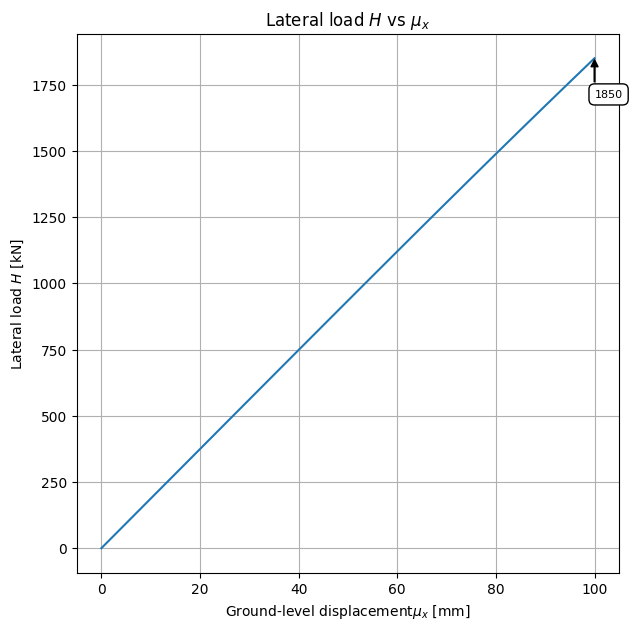

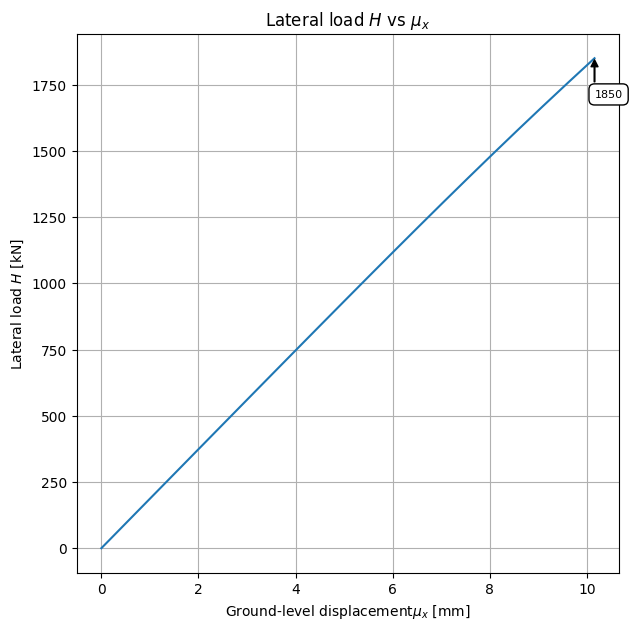

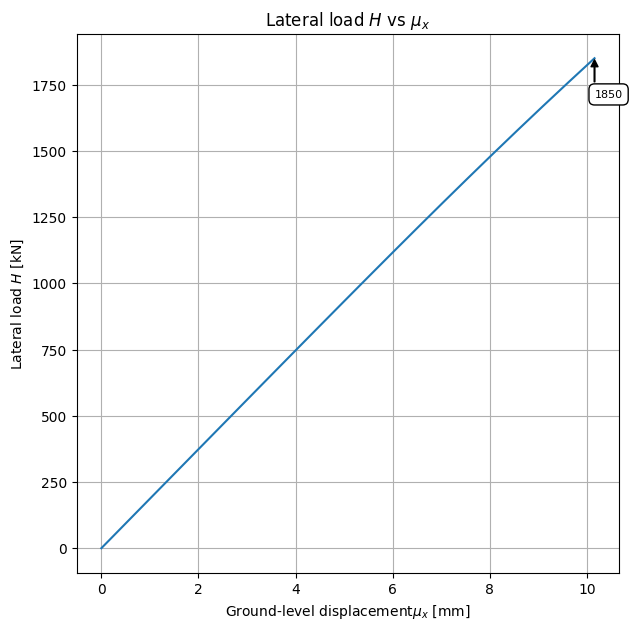

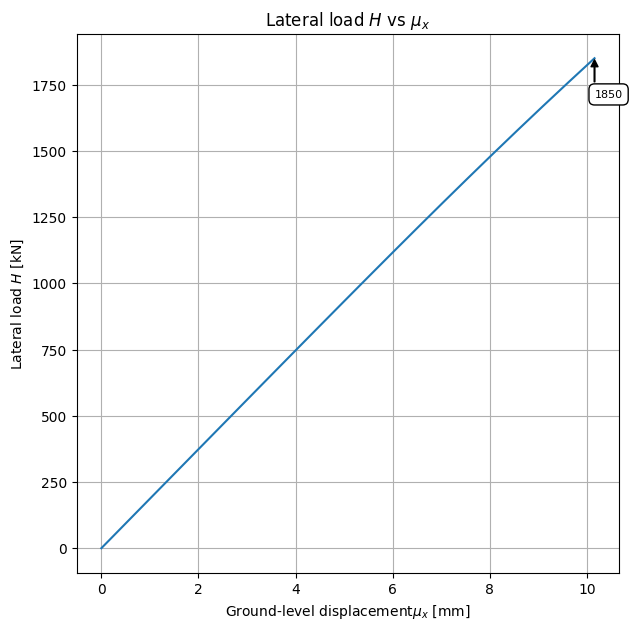

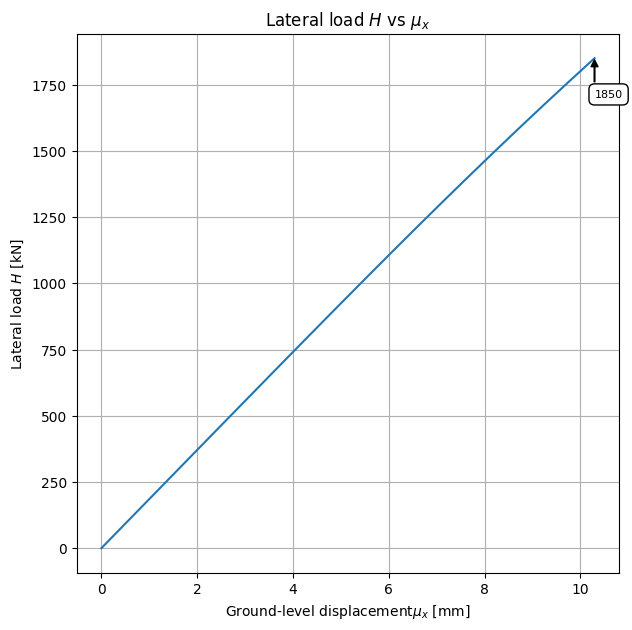

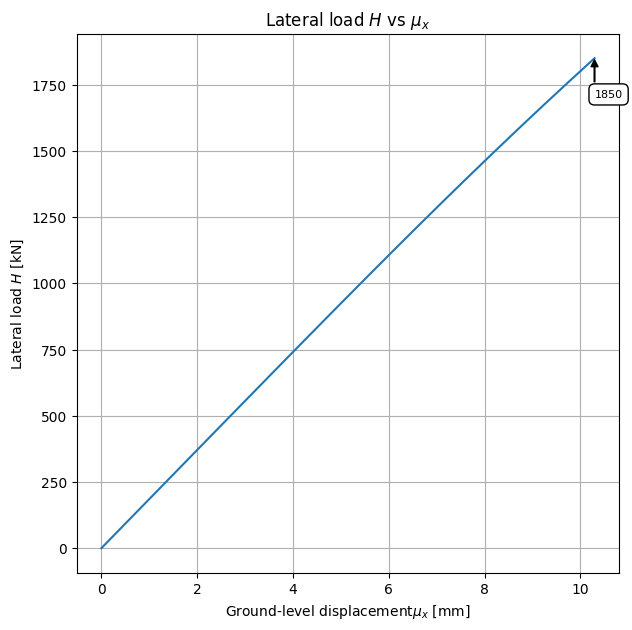

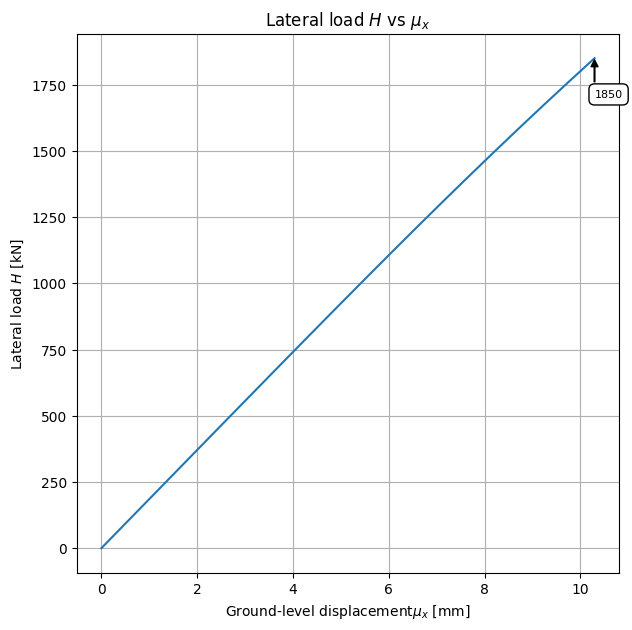

In [4]:
params = initialize_parameters(
    order = 1, #order of approximation functions
    case_name = "pile",
    custom_mesh_filepath="/mofem_install/jupyter/thomas/mfront_example_test/user_data/pile_1.cub", 
    base = "hex",
    soil_model=cm.PropertyTypeEnum.dpHYPER,
    
    final_time = 0.1, # [s]
    time_step = 0.1 / 20, # [s]
    options_file = "/mofem_install/jupyter/thomas/mfront_example_test/param_file.petsc",
    
    save_gauss = 0,
    convert_gauss = 0,
    
    FEA_completed=False,
    # days_since_epoch=107,
    # sim_otd=9,
    
    # prescribed_force = cm.ForceBoundaryCondition(fx=0,fy=0,fz=0),
    prescribed_disp = cm.SurfaceBoundaryCondition(disp_ux=1, disp_uy=0 ,disp_uz=0),
    
    points_of_interest = [
        cm.Point(x=1,y=0,z=10),
        cm.Point(x=-1,y=0,z=0),
        cm.Point(x=1,y=0,z=0),
        # cm.Point(x=-1.03701,y=0,z=0),
        # cm.Point(x=-1.07402,y=0,z=0),
    ],
    line_of_interest = cm.Line(pt1=cm.Point(x=-1,y=0,z=10), pt2=cm.Point(x=-1,y=0,z=-40),),
    
) # 2. Simulation Parameters    
params = setup.setup(params) # 3. Log paths and meta
if params.FEA_completed:
    core.export_to_vtk(params)
    postprocess.extract(params)
    postprocess.calculate(params)
    postprocess.plot(params)
    pass
else:
    core.generate_mesh(params) # 4. Generate the mesh
    core.mofem_compute(params) # 5. Running the analysis and export to .vtk file format
    core.export_to_vtk(params)
    postprocess.extract(params)
    postprocess.calculate(params)
    postprocess.plot(params)
    